# CNN Model Analysis

In this notebook, we will train 3 different deep learning model to correctly classify images in the CIFAR-10 dataset using CNN.

Models

* Model 1 will train a simple CNN model with 50 epochs but with early stopping
* Model 2 will train the same but optimized version of the simple CNN model network with 50 epochs wihtout early stopping
* Model 3 will train the same but optimized version of the simple CNN model network with 50 epochs with early stopping

### 1. Import all the necessary libraries

In [2]:
import torch
import torch.nn as nn
from torch.optim import Adam
import torchvision
import torchvision.transforms.v2 as transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from torchvision.transforms import functional as F
import copy

### 2. Confirm PyTorch can recognize GPU

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
torch.cuda.is_available()

True

### 3. Exploratory Data Analysis (EDA) and Data Preprocessing

Loading and observing both the train and test datasets for CIFAR-10

In [4]:
trainset = torchvision.datasets.CIFAR10(
    root = 'dataset',
    train= True,
    download= True,
)

testset = torchvision.datasets.CIFAR10(
    root = 'dataset',
    train= False, # Training set so False
    download= True,
)

Files already downloaded and verified
Files already downloaded and verified


Printing the `trainset` and `testset`

By executing the following cells, we can see that [TorchVision](https://pytorch.org/vision/stable/index.html) has partitioned 50,000 of these PIL Images for training, and 10,000 for testing (after training).

In [5]:
trainset

Dataset CIFAR10
    Number of datapoints: 50000
    Root location: dataset
    Split: Train

In [6]:
testset

Dataset CIFAR10
    Number of datapoints: 10000
    Root location: dataset
    Split: Test

Taking one instance of the `trainset` for deeper analysis

In [7]:
trainset[6]

(<PIL.Image.Image image mode=RGB size=32x32>, 2)

Storing a `trainset` instance (input image and output label) in `x` and `y`

In [8]:
x, y = trainset[45]

In [9]:
type(x)

PIL.Image.Image

In [10]:
type(y)

int

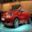

In [11]:
x

In [12]:
y

1

In [13]:
x.size

(32, 32)

Converting the image into a tensor

In [14]:
transf = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
    ])
x_tensor = transf(x)

c:\Users\Taliya Mira\anaconda3\envs\torch\lib\site-packages\torchvision\transforms\v2\_deprecated.py:42: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])`.Output is equivalent up to float precision.
  warnings.warn(


Stroing `y` in `solution` variable for future reference to check models predicted output

In [15]:
solution = y

In [16]:
solution

1

Verifying the data type, minimum and maximum values, and size of `x_tensor`

In [17]:
x_tensor.dtype

torch.float32

In [18]:
x_tensor.min()

tensor(-1.)

In [19]:
x_tensor.max()

tensor(0.9922)

In [20]:
x_tensor.shape

torch.Size([3, 32, 32])

Observing the output labels

Printing each label with its corresponding output class and storing it in a list

In [21]:
classes = []
for label, class_name in enumerate(trainset.classes):
    print(f"Label {label}: {class_name}")
    classes.append(class_name)

Label 0: airplane
Label 1: automobile
Label 2: bird
Label 3: cat
Label 4: deer
Label 5: dog
Label 6: frog
Label 7: horse
Label 8: ship
Label 9: truck


Printing the list

In [22]:
classes

['airplane',
 'automobile',
 'bird',
 'cat',
 'deer',
 'dog',
 'frog',
 'horse',
 'ship',
 'truck']

Converting the entire RGB tensor (all 3 channels) into a PIL image

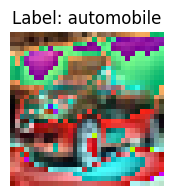

In [23]:
image = F.to_pil_image(x_tensor)
plt.figure(figsize=(2, 2))
plt.imshow(image)
plt.title(f"Label: {classes[solution]}")
plt.axis('off')
plt.show()

In [24]:
x_tensor

tensor([[[-0.5765, -0.5373, -0.5608,  ...,  0.0431,  0.0275,  0.0353],
         [-0.5373, -0.5137, -0.5686,  ...,  0.5137,  0.5686,  0.5451],
         [-0.6784, -0.6784, -0.7176,  ...,  0.5843,  0.5373,  0.4902],
         ...,
         [-0.1765, -0.2392, -0.2471,  ..., -0.2314, -0.2157, -0.2157],
         [-0.3255, -0.2471, -0.2392,  ..., -0.2627, -0.2314, -0.2157],
         [-0.4510, -0.2784, -0.1137,  ..., -0.2314, -0.2471, -0.2784]],

        [[-0.7569, -0.7333, -0.7098,  ..., -0.2784, -0.3020, -0.2627],
         [-0.7020, -0.6941, -0.7176,  ...,  0.0588,  0.1294,  0.1137],
         [-0.7961, -0.8039, -0.8353,  ...,  0.1294,  0.1059,  0.0667],
         ...,
         [ 0.2627,  0.2784,  0.3333,  ...,  0.1373,  0.0824,  0.0196],
         [ 0.1686,  0.2314,  0.2863,  ..., -0.0039, -0.0118, -0.0275],
         [ 0.0667,  0.1451,  0.3255,  ..., -0.0510, -0.0824, -0.1216]],

        [[-0.8588, -0.8510, -0.8275,  ..., -0.5843, -0.6157, -0.5843],
         [-0.7961, -0.7961, -0.8039,  ..., -0

Before, we only applied `transf` to one value. There are multiple ways we can apply our list of transforms to a dataset. One such way is to set it to a dataset's transform variable.

In [25]:
trainset.transform = transf
testset.transform = transf

`x` will be used as an input to check the models prediction so we will convert send it to device.

the Flatten layer sees three vectors as opposed to one 2D matrix. To fix this, we can "batch" our data by adding an extra pair of brackets.

In [26]:
for x, y in trainset:
    x=x[None,:]

Checking the device

In [27]:
x.device

device(type='cpu')

Moving `x` to a GPU using the `.cuda` method

In [28]:
x_gpu = x.cuda()
x_gpu.device

device(type='cuda', index=0)

Printing the number of classes in the dataset

In [29]:
class_names = trainset.classes
len(class_names)

10

Checking if the classes are balanced in the `trainset` and `testset` using figures.

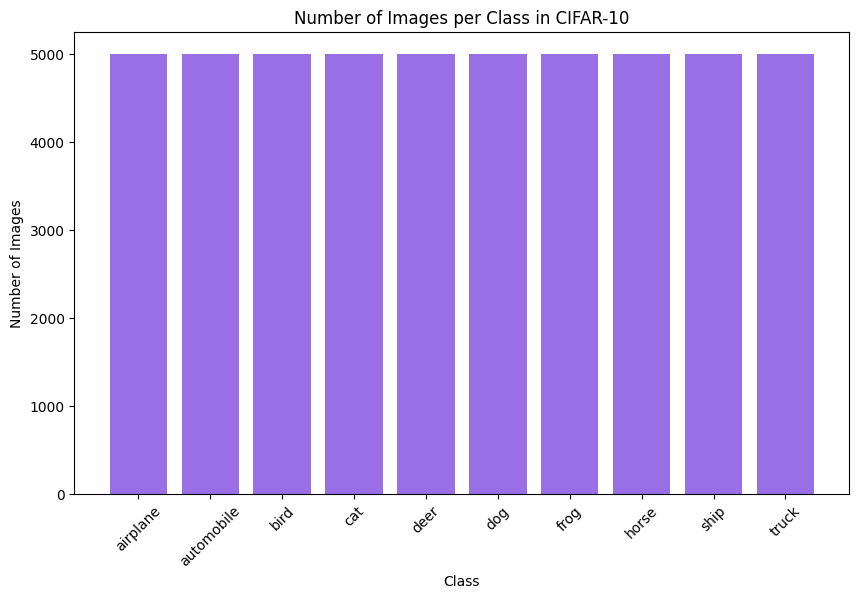

In [30]:
class_counts = [0] * len(class_names)

for _, label in trainset:
    class_counts[label] += 1

plt.figure(figsize=(10, 6))
plt.bar(class_names, class_counts, color='#996fe6')
plt.xlabel('Class')
plt.ylabel('Number of Images')
plt.title('Number of Images per Class in CIFAR-10')
plt.xticks(rotation=45)
plt.show()

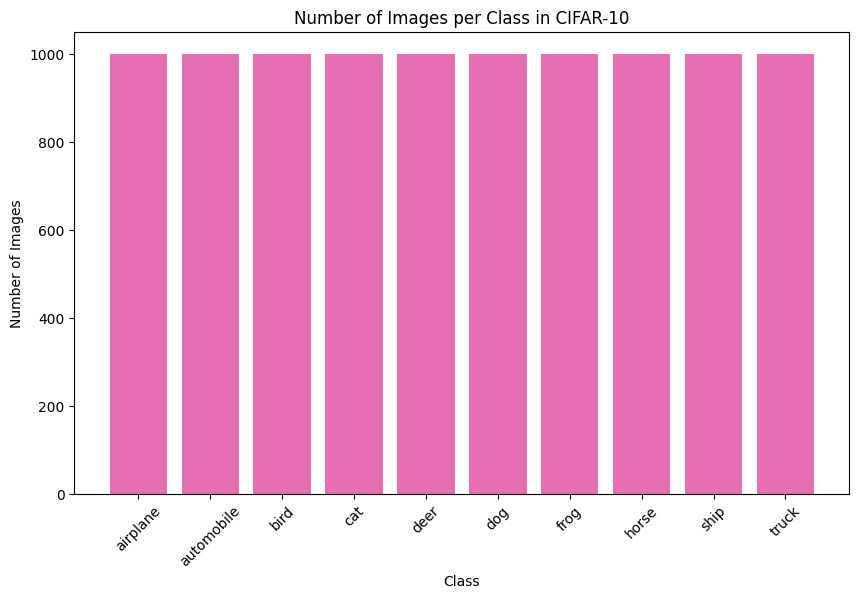

In [31]:
class_counts = [0] * len(class_names)

for _, label in testset:
    class_counts[label] += 1

plt.figure(figsize=(10, 6))
plt.bar(class_names, class_counts, color='#e66fb3')
plt.xlabel('Class')
plt.ylabel('Number of Images')
plt.title('Number of Images per Class in CIFAR-10')
plt.xticks(rotation=45)
plt.show()

### 4. Model Development, Training, Evaluation, and Analysis

Loading Data

In [32]:
trainloader = DataLoader(
    trainset,
    batch_size= 32,
    shuffle= True,
)

testloader = DataLoader(testset, batch_size=32)

In order to create these weights, Pytorch needs to know the size of our inputs and how many neurons we want to create. We store it in the variable `input_size` and furthemore we store the number of classes to `num_classes`.

In [33]:
input_size = 3 * 32 * 32
num_classes = 10

Assigning the size of our datasets to `N` where `n` is synonymous with the `batch size`.

In [34]:
train_N = len(trainloader.dataset)
test_N = len(testloader.dataset)

Making a function to calculate the accuracy for each batch. The result is a fraction of the total accuracy, so we can add the accuracy of each batch together to get the total.

In [35]:
def get_batch_accuracy(output, y, N):
    pred = output.argmax(dim=1, keepdim=True)
    correct = pred.eq(y.view_as(pred)).sum().item()
    return correct / N

I will use a type of loss function called [CrossEntropy](https://pytorch.org/docs/stable/generated/torch.nn.CrossEntropyLoss.html) which is designed to grade if a model predicted the correct category from a group of categories.

In [36]:
loss_function = nn.CrossEntropyLoss()

Now, the models will be explained in details but since they are similar, I will not repeat the explanation of similar parts.

We have used CNN (Convolutional Neural Network) which is known for extracting features from an image. In our project, we used a model that was inspired by the following image:

![Online Image](https://miro.medium.com/v2/resize:fit:720/format:webp/1*kkyW7BR5FZJq4_oBTx3OPQ.png "CNN Architecture")


### *********************************************************************************************************************************************************
#### 5.1 Model 1 Developement and Training (Using a simple CNN model with 50 epochs with early stopping)

The model architecture consists the following layers:
* 3 Convoutional layers (`Conv2d()`). Each having an activation function called ReLu (`ReLU()`) which introduces non-linearity in the data to allow the network to capture complex patterns and a Max Pooling layer (`MaxPool2d()`) which is responisble of reducing the spacial dimension of the image. This reduction in dimension, helps  to reduce the computation and help the model generalize better by focusing on the most prominent features.
* 1 Flatten Layer (`Flatten()`): This layer flattens the tensor into a 1D vector to feed it into the fully connected layers.
* 3 Linear (Fully connected layer) (`Linear()`): These layers are the main layers used in neural networks and they are responsible for classifying the images based on the learned features. This layer takes the output size of the previous layer as an input.  

The parameters used in the Convoutional layers are as follows:
* Input channels: The number of input channels (In the case of CIFAR-10, its 3 as the images are RGB)
* Output channels: The number of output channels
* Kernel size: The kernel size
* Stride: The stride
* Padding: The padding 


In [37]:
#defining the layers
layers1 = nn.Sequential(
    # Convolutional layer 1
    nn.Conv2d(3, 32, 3, 1, 1),  
    nn.ReLU(),
    nn.MaxPool2d(2, 2),  

    # Convolutional layer 2
    nn.Conv2d(32, 64, 3, 1, 1), 
    nn.ReLU(),
    nn.MaxPool2d(2, 2),  

    # Convolutional layer 3
    nn.Conv2d(64, 128, 3, 1, 1),  
    nn.ReLU(),
    nn.MaxPool2d(2, 2),

    # Flatten the output of the convolutional layers to feed into fully connected layers
    nn.Flatten(),

    # Fully connected layers
    nn.Linear(128 * 4 * 4, 512),  
    nn.ReLU(),

    nn.Linear(512, 512),
    nn.ReLU(),

    nn.Linear(512, 10)  # Output layer (10 classes for CIFAR-10)
)

Unpacking all the layers

In [38]:
model1 = nn.Sequential(*layers1)
model1

Sequential(
  (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU()
  (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (4): ReLU()
  (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (6): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (7): ReLU()
  (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (9): Flatten(start_dim=1, end_dim=-1)
  (10): Linear(in_features=2048, out_features=512, bias=True)
  (11): ReLU()
  (12): Linear(in_features=512, out_features=512, bias=True)
  (13): ReLU()
  (14): Linear(in_features=512, out_features=10, bias=True)
)

In [39]:
model1.to(device)

Sequential(
  (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU()
  (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (4): ReLU()
  (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (6): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (7): ReLU()
  (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (9): Flatten(start_dim=1, end_dim=-1)
  (10): Linear(in_features=2048, out_features=512, bias=True)
  (11): ReLU()
  (12): Linear(in_features=512, out_features=512, bias=True)
  (13): ReLU()
  (14): Linear(in_features=512, out_features=10, bias=True)
)

Moving all the model parameters to the device

In [40]:
next(model1.parameters()).device

device(type='cuda', index=0)

Using an optimizer called Adam

In [41]:
optimizer = Adam(model1.parameters())

The function we will use for training

In [42]:
def train1():
    loss = 0
    accuracy = 0

    model1.train()
    for t1, t2 in trainloader:
        t1, t2 = t1.to(device), t2.to(device)
        output = model1(t1)
        optimizer.zero_grad()
        batch_loss = loss_function(output, t2)
        batch_loss.backward()
        optimizer.step()

        loss += batch_loss.item()
        accuracy += get_batch_accuracy(output, t2, train_N)

    print('Train - Loss: {:.4f} Accuracy: {:.4f}'.format(loss, accuracy))
    return loss, accuracy

The function we will use for testing

In [43]:
def validate1():
    loss = 0
    accuracy = 0

    model1.eval()
    with torch.no_grad():
        for v1, v2 in testloader:
            v1, v2 = v1.to(device), v2.to(device)
            output = model1(v1)

            loss += loss_function(output, v2).item()
            accuracy += get_batch_accuracy(output, v2, test_N)

    print('Valid - Loss: {:.4f} Accuracy: {:.4f}'.format(loss, accuracy))
    return loss, accuracy

Here is the core of our project, the most exciting part. We begin training and testing our model to see how it performs.

In [44]:
epochs = 50

train_losses1 = []
train_accuracies1 = []
valid_losses1 = []
valid_accuracies1 = []

#Initialize Variables for EarlyStopping
best_loss = float('inf')
best_model_weights = None
patience = 3

for epoch in range(epochs):
    print('Epoch: {}'.format(epoch))
    t1,t2 = train1()

    train_losses1.append(t1)
    train_accuracies1.append(t2)

    v1,v2 = validate1()

    valid_losses1.append(v1)
    valid_accuracies1.append(v2)

    # Early stopping
    if v1 < best_loss:
        best_loss = v1
        best_model_weights = copy.deepcopy(model1.state_dict())  # Deep copy here
        patience = 3  # Reset patience counter
    else:
        patience -= 1
        if patience == 0:
            break

Epoch: 0
Train - Loss: 2090.2393 Accuracy: 0.5105
Valid - Loss: 322.1918 Accuracy: 0.6402
Epoch: 1
Train - Loss: 1364.1502 Accuracy: 0.6954
Valid - Loss: 256.2980 Accuracy: 0.7163
Epoch: 2
Train - Loss: 1063.8998 Accuracy: 0.7615
Valid - Loss: 241.8127 Accuracy: 0.7333
Epoch: 3
Train - Loss: 858.6291 Accuracy: 0.8062
Valid - Loss: 232.4513 Accuracy: 0.7545
Epoch: 4
Train - Loss: 674.8515 Accuracy: 0.8472
Valid - Loss: 255.1292 Accuracy: 0.7483
Epoch: 5
Train - Loss: 527.2164 Accuracy: 0.8798
Valid - Loss: 259.9756 Accuracy: 0.7546
Epoch: 6
Train - Loss: 416.7486 Accuracy: 0.9050
Valid - Loss: 277.1934 Accuracy: 0.7542


To evaluate our model's performance on both the training and validation data, we utilized "Accuracy" as the evaluation metric and "CrossEntropyLoss" to compute the loss given that this is a multi-class classification problem. Moreover, to anaylze the performance of the model, we used 2 different plots called "Loss over Epochs" and "Accuracy over Epochs".

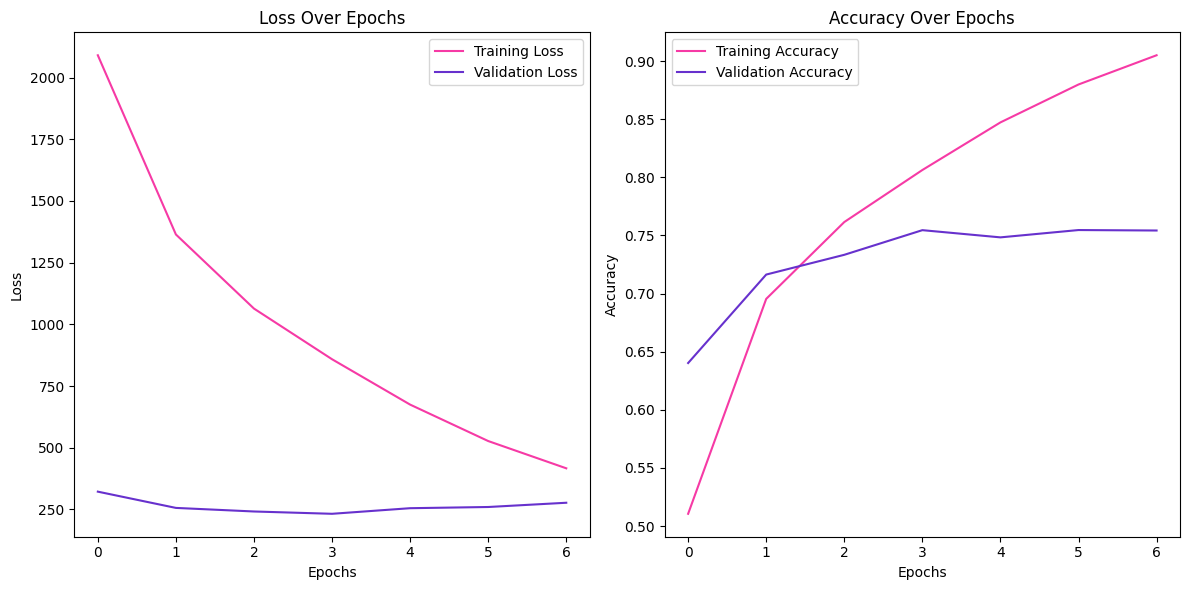

In [45]:
# Plotting loss and accuracy graphs after training
plt.figure(figsize=(12, 6))

# Loss plot
plt.subplot(1, 2, 1)
plt.plot(train_losses1, label='Training Loss',color='#f63aa5')
plt.plot(valid_losses1, label='Validation Loss',color='#6731cd')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss Over Epochs')
plt.legend()

# Accuracy plot
plt.subplot(1, 2, 2)
plt.plot(train_accuracies1, label='Training Accuracy',color='#f63aa5')
plt.plot(valid_accuracies1, label='Validation Accuracy',color='#6731cd')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Accuracy Over Epochs')
plt.legend()

plt.tight_layout()
plt.show()

1. Loss over Epochs:
The training loss started off really high but as the number of epochs increased, it decreased. This is an indication that our model was learning very well. On the other hand, the validation loss decreased until the 4th epoch and after that we noticed that the loss started increasing while the training loss was still decreasing.

2. Accuracy over Epochs:
Both the training and validation accuracy started increasing till around 1.5 epochs. After that, we noticed that the traning accuracy was increasing rapidly meanwhile the validation was increasing slowly. Suddenly at the 4th epoch, the validation accuracy starts to decrease while the training accuracy is still increasing. 

    What does this mean?
    Since the model has started to perform very well on the training data but bad on the validation data, this is a clear indication that our model has started to overfit. 

    Was the analysis right?
    Since the Early Stopping ensured the model stops training after the 6th epoch, we were right about the overfitting.

Confusion Matrix for `model1`

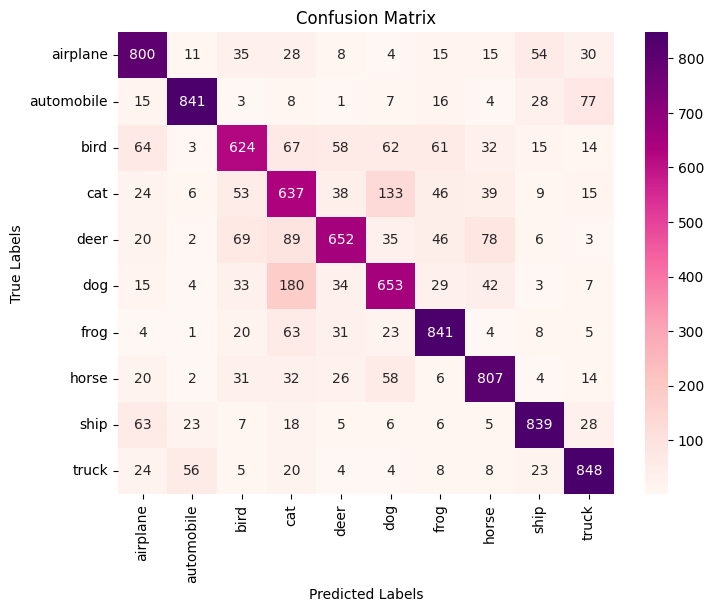

In [62]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import torch

# Step 1: Generate Predictions on the Test Set
all_preds = []
all_labels = []

model1.eval()  # Set model to evaluation mode
with torch.no_grad():
    for images, labels in testloader:
        images, labels = images.to(device), labels.to(device)
        outputs = model1(images)
        _, preds = torch.max(outputs, 1)  # Get predicted class (highest probability)
        all_preds.extend(preds.cpu().numpy())  # Convert predictions to NumPy array
        all_labels.extend(labels.cpu().numpy())  # Convert true labels to NumPy array

# Step 2: Compute the Confusion Matrix
cm = confusion_matrix(all_labels, all_preds)

# Step 3: Visualize the Confusion Matrix
class_names = testset.classes  # Class names from the CIFAR-10 dataset
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="RdPu", xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix")
plt.show()

### *******************************************************************************************************************************************************
#### 5.2 Model 2 Developement and Training (Opimized CNN model with 50 epochs)

The model architecture is the same as `model1` but it is optimized to prevent overfitting. We have used the Dropout layer (`Dropout()`) which disables/deactivates some neurons during training. It doesn't delete the neurons rather just disables them to prevent the model from learning too much from the training data. 

We experimented with various placements and values of the dropout to see what gives us the best performance. The final placements and values we chose are as follows:
* 1 after Convoutional layer 1 with a value of 0.25 (25% dropped)
* 1 after Convoutional layer 2 with a value of 0.5 (50% dropped)
* 1 after Fully connected layer 1 with a value of 0.25 (25% dropped)
* 1 after Fully connected layer 2 with a value of 0.5 (50% dropped)

In [50]:
layers2 = nn.Sequential(
    nn.Conv2d(3, 32, 3, 1, 1), 
    nn.ReLU(),
    nn.MaxPool2d(2, 2),
    nn.Dropout(0.25),  # Dropout after first pooling

    nn.Conv2d(32, 64, 3, 1, 1),  
    nn.ReLU(),
    nn.MaxPool2d(2, 2),
    nn.Dropout(0.5),  # Dropout after second pooling

    nn.Conv2d(64, 128, 3, 1, 1),
    nn.ReLU(),
    nn.MaxPool2d(2, 2),

    nn.Flatten(),
    nn.Linear(128 * 4 * 4, 512),  # First FC layer
    nn.ReLU(),
    nn.Dropout(0.25),  # Dropout after first FC layer

    nn.Linear(512, 512),  # Second FC layer
    nn.ReLU(),
    nn.Dropout(0.5),  # Dropout after second FC layer

    nn.Linear(512, 10)  # Output layer
)

In [51]:
model2 = nn.Sequential(*layers2)
model2

Sequential(
  (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU()
  (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (3): Dropout(p=0.25, inplace=False)
  (4): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (5): ReLU()
  (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (7): Dropout(p=0.5, inplace=False)
  (8): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (9): ReLU()
  (10): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (11): Flatten(start_dim=1, end_dim=-1)
  (12): Linear(in_features=2048, out_features=512, bias=True)
  (13): ReLU()
  (14): Dropout(p=0.25, inplace=False)
  (15): Linear(in_features=512, out_features=512, bias=True)
  (16): ReLU()
  (17): Dropout(p=0.5, inplace=False)
  (18): Linear(in_features=512, out_features=10, bias=True)
)

In [52]:
model2.to(device)

Sequential(
  (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU()
  (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (3): Dropout(p=0.25, inplace=False)
  (4): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (5): ReLU()
  (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (7): Dropout(p=0.5, inplace=False)
  (8): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (9): ReLU()
  (10): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (11): Flatten(start_dim=1, end_dim=-1)
  (12): Linear(in_features=2048, out_features=512, bias=True)
  (13): ReLU()
  (14): Dropout(p=0.25, inplace=False)
  (15): Linear(in_features=512, out_features=512, bias=True)
  (16): ReLU()
  (17): Dropout(p=0.5, inplace=False)
  (18): Linear(in_features=512, out_features=10, bias=True)
)

In [53]:
next(model2.parameters()).device

device(type='cuda', index=0)

In [54]:
optimizer = Adam(model2.parameters())

In [55]:
def train2():
    loss = 0
    accuracy = 0

    model2.train()
    for t1, t2 in trainloader:
        t1, t2 = t1.to(device), t2.to(device)
        output = model2(t1)
        optimizer.zero_grad()
        batch_loss = loss_function(output, t2)
        batch_loss.backward()
        optimizer.step()

        loss += batch_loss.item()
        accuracy += get_batch_accuracy(output, t2, train_N)

    print('Train - Loss: {:.4f} Accuracy: {:.4f}'.format(loss, accuracy))
    return loss, accuracy

In [56]:
def validate2():
    loss = 0
    accuracy = 0

    model2.eval()
    with torch.no_grad():
        for v1, v2 in testloader:
            v1, v2 = v1.to(device), v2.to(device)
            output = model2(v1)

            loss += loss_function(output, v2).item()
            accuracy += get_batch_accuracy(output, v2, test_N)

    print('Valid - Loss: {:.4f} Accuracy: {:.4f}'.format(loss, accuracy))
    return loss, accuracy

We begin training and testing our model to see how it performs

In [57]:
epochs = 50

train_losses2 = []
train_accuracies2 = []
valid_losses2 = []
valid_accuracies2 = []

for epoch in range(epochs):
    print('Epoch: {}'.format(epoch))
    t1,t2 = train2()

    train_losses2.append(t1)
    train_accuracies2.append(t2)

    v1,v2 = validate2()

    valid_losses2.append(v1)
    valid_accuracies2.append(v2)

Epoch: 0
Train - Loss: 2369.9361 Accuracy: 0.4420
Valid - Loss: 371.0538 Accuracy: 0.5821
Epoch: 1
Train - Loss: 1831.2674 Accuracy: 0.5853
Valid - Loss: 323.1356 Accuracy: 0.6430
Epoch: 2
Train - Loss: 1618.8283 Accuracy: 0.6378
Valid - Loss: 287.4831 Accuracy: 0.6749
Epoch: 3
Train - Loss: 1492.9620 Accuracy: 0.6665
Valid - Loss: 261.3583 Accuracy: 0.7050
Epoch: 4
Train - Loss: 1412.6774 Accuracy: 0.6849
Valid - Loss: 246.2444 Accuracy: 0.7250
Epoch: 5
Train - Loss: 1353.2250 Accuracy: 0.7009
Valid - Loss: 247.7197 Accuracy: 0.7243
Epoch: 6
Train - Loss: 1312.4167 Accuracy: 0.7104
Valid - Loss: 245.7498 Accuracy: 0.7319
Epoch: 7
Train - Loss: 1280.2802 Accuracy: 0.7184
Valid - Loss: 234.6440 Accuracy: 0.7411
Epoch: 8
Train - Loss: 1238.6708 Accuracy: 0.7274
Valid - Loss: 229.7777 Accuracy: 0.7441
Epoch: 9
Train - Loss: 1214.0470 Accuracy: 0.7315
Valid - Loss: 231.4003 Accuracy: 0.7450
Epoch: 10
Train - Loss: 1183.8627 Accuracy: 0.7381
Valid - Loss: 228.5536 Accuracy: 0.7527
Epoch: 11

To evaluate our model's performance on both the training and validation data, we utilized "Accuracy" as the evaluation metric and "CrossEntropyLoss" to compute the loss given that this is a multi-class classification problem. Moreover, to anaylze the performance of the model, we used 2 different plots called "Loss over Epochs" and "Accuracy over Epochs".

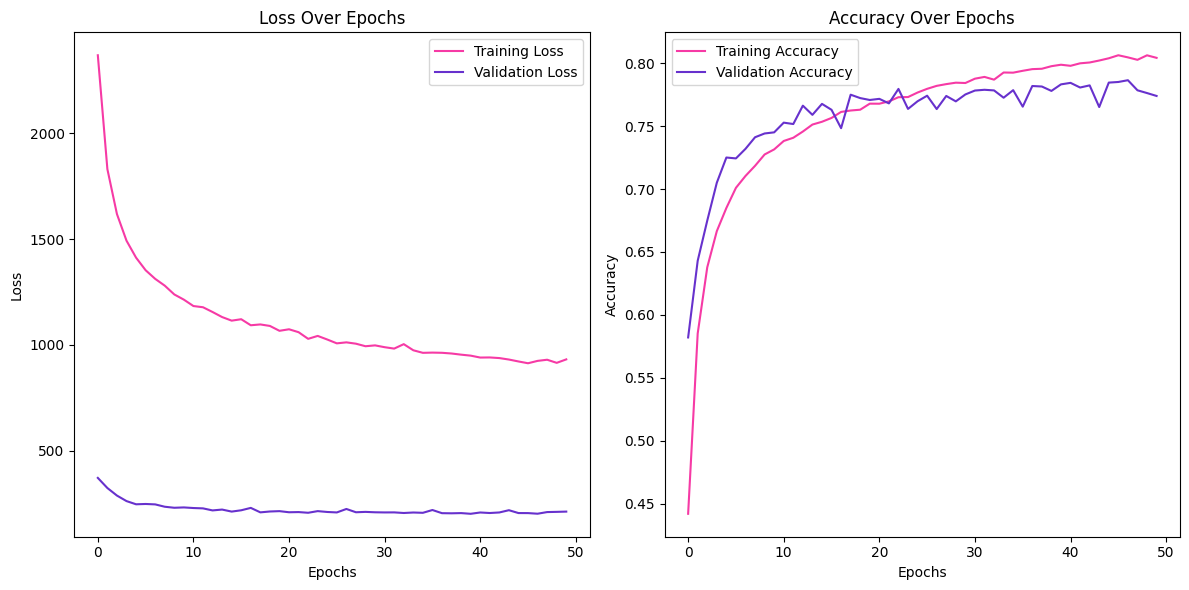

In [60]:
# Plotting loss and accuracy graphs after training
plt.figure(figsize=(12, 6))

# Loss plot
plt.subplot(1, 2, 1)
plt.plot(train_losses2, label='Training Loss',color='#f63aa5')
plt.plot(valid_losses2, label='Validation Loss',color='#6731cd')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss Over Epochs')
plt.legend()

# Accuracy plot
plt.subplot(1, 2, 2)
plt.plot(train_accuracies2, label='Training Accuracy',color='#f63aa5')
plt.plot(valid_accuracies2, label='Validation Accuracy',color='#6731cd')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Accuracy Over Epochs')
plt.legend()

plt.tight_layout()
plt.show()

1. Loss over Epochs:
The training loss started off really high but as the number of epochs increased, it decreased. This is an indication that our model was learning very well. On the other hand, the validation loss decreased with the training loss too. This is a good indication that the model is not overfitting anymore.

2. Accuracy over Epochs:
Both the training and validation accuracy started increasing together. There were a lot of fluctuations in the validation accuracy but thats not a problem as long as it is almost equal to the training accuracy. At around 20 epochs, we notice the accuracies stay the same after which the validation accuracy begins to reduce a little. This could be an indication that model is starting to overfit, but the dropout has prevented this by a lot. If we continued training the model on more epochs, the model would overfit given the current results. To prevent this issue, we have implemented another model called `model3`, which is exactly the same but we used early stopping to prevent this issue.

Confusion Matrix for `model2`

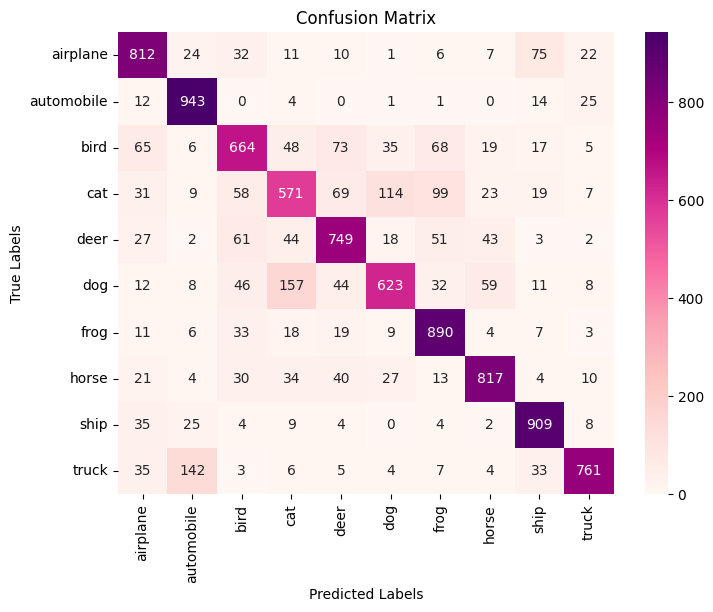

In [76]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import torch

# Step 1: Generate Predictions on the Test Set
all_preds = []
all_labels = []

model2.eval()  # Set model to evaluation mode
with torch.no_grad():
    for images, labels in testloader:
        images, labels = images.to(device), labels.to(device)
        outputs = model2(images)
        _, preds = torch.max(outputs, 1)  
        all_preds.extend(preds.cpu().numpy())  
        all_labels.extend(labels.cpu().numpy())  

# Step 2: Compute the Confusion Matrix
cm = confusion_matrix(all_labels, all_preds)

# Step 3: Visualize the Confusion Matrix
class_names = testset.classes  # Class names from the CIFAR-10 dataset
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="RdPu", xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix")
plt.show()

### *******************************************************************************************************************************************************
#### 5.3 Model 3 Developement and Training (Opimized CNN model with 50 epochs with Early Stopping)

The model architecture is the same as `model2` but it is optimized to prevent overfitting with early stopping.

In [63]:
layers3 = nn.Sequential(
    nn.Conv2d(3, 32, 3, 1, 1),  # Conv1
    nn.ReLU(),
    nn.MaxPool2d(2, 2),
    nn.Dropout(0.25),  # Dropout after first pooling

    nn.Conv2d(32, 64, 3, 1, 1),  # Conv2
    nn.ReLU(),
    nn.MaxPool2d(2, 2),
    nn.Dropout(0.5),  # Dropout after second pooling

    nn.Conv2d(64, 128, 3, 1, 1),  # Conv3
    nn.ReLU(),
    nn.MaxPool2d(2, 2),

    nn.Flatten(),
    nn.Linear(128 * 4 * 4, 512),  # First FC layer
    nn.ReLU(),
    nn.Dropout(0.25),  # Dropout after first FC layer

    nn.Linear(512, 512),  # Second FC layer
    nn.ReLU(),
    nn.Dropout(0.5),  # Dropout after second FC layer

    nn.Linear(512, 10)  # Output layer
)

In [64]:
model3 = nn.Sequential(*layers3)
model3

Sequential(
  (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU()
  (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (3): Dropout(p=0.25, inplace=False)
  (4): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (5): ReLU()
  (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (7): Dropout(p=0.5, inplace=False)
  (8): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (9): ReLU()
  (10): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (11): Flatten(start_dim=1, end_dim=-1)
  (12): Linear(in_features=2048, out_features=512, bias=True)
  (13): ReLU()
  (14): Dropout(p=0.25, inplace=False)
  (15): Linear(in_features=512, out_features=512, bias=True)
  (16): ReLU()
  (17): Dropout(p=0.5, inplace=False)
  (18): Linear(in_features=512, out_features=10, bias=True)
)

In [65]:
model3.to(device)

Sequential(
  (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU()
  (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (3): Dropout(p=0.25, inplace=False)
  (4): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (5): ReLU()
  (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (7): Dropout(p=0.5, inplace=False)
  (8): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (9): ReLU()
  (10): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (11): Flatten(start_dim=1, end_dim=-1)
  (12): Linear(in_features=2048, out_features=512, bias=True)
  (13): ReLU()
  (14): Dropout(p=0.25, inplace=False)
  (15): Linear(in_features=512, out_features=512, bias=True)
  (16): ReLU()
  (17): Dropout(p=0.5, inplace=False)
  (18): Linear(in_features=512, out_features=10, bias=True)
)

In [66]:
next(model3.parameters()).device

device(type='cuda', index=0)

In [67]:
optimizer = Adam(model3.parameters())

In [68]:
def train3():
    loss = 0
    accuracy = 0

    model3.train()
    for t1, t2 in trainloader:
        t1, t2 = t1.to(device), t2.to(device)
        output = model3(t1)
        optimizer.zero_grad()
        batch_loss = loss_function(output, t2)
        batch_loss.backward()
        optimizer.step()

        loss += batch_loss.item()
        accuracy += get_batch_accuracy(output, t2, train_N)

    print('Train - Loss: {:.4f} Accuracy: {:.4f}'.format(loss, accuracy))
    return loss, accuracy

In [69]:
def validate3():
    loss = 0
    accuracy = 0

    model3.eval()
    with torch.no_grad():
        for v1, v2 in testloader:
            v1, v2 = v1.to(device), v2.to(device)
            output = model3(v1)

            loss += loss_function(output, v2).item()
            accuracy += get_batch_accuracy(output, v2, test_N)

    print('Valid - Loss: {:.4f} Accuracy: {:.4f}'.format(loss, accuracy))
    return loss, accuracy

We begin training and testing our model to see how it performs.

In [70]:
epochs = 50

train_losses3 = []
train_accuracies3 = []
valid_losses3 = []
valid_accuracies3 = []

#Initialize Variables for EarlyStopping
best_loss = float('inf')
best_model_weights = None
patience = 5

for epoch in range(epochs):
    print('Epoch: {}'.format(epoch))
    t1,t2 = train3()

    train_losses3.append(t1)
    train_accuracies3.append(t2)

    v1,v2 = validate3()

    valid_losses3.append(v1)
    valid_accuracies3.append(v2)

    # Early stopping
    if v1 < best_loss:
        best_loss = v1
        best_model_weights = copy.deepcopy(model3.state_dict())  # Deep copy here
        patience = 5 # Reset patience counter
    else:
        patience -= 1
        if patience == 0:
            break

Epoch: 0
Train - Loss: 2423.7696 Accuracy: 0.4274
Valid - Loss: 379.5727 Accuracy: 0.5670
Epoch: 1
Train - Loss: 1876.5387 Accuracy: 0.5707
Valid - Loss: 328.3179 Accuracy: 0.6248
Epoch: 2
Train - Loss: 1675.8908 Accuracy: 0.6226
Valid - Loss: 304.1301 Accuracy: 0.6468
Epoch: 3
Train - Loss: 1552.3277 Accuracy: 0.6518
Valid - Loss: 273.7635 Accuracy: 0.6977
Epoch: 4
Train - Loss: 1474.8847 Accuracy: 0.6691
Valid - Loss: 271.5900 Accuracy: 0.7037
Epoch: 5
Train - Loss: 1422.6682 Accuracy: 0.6833
Valid - Loss: 255.7939 Accuracy: 0.7150
Epoch: 6
Train - Loss: 1372.6748 Accuracy: 0.6943
Valid - Loss: 248.7754 Accuracy: 0.7216
Epoch: 7
Train - Loss: 1332.6598 Accuracy: 0.7047
Valid - Loss: 243.9229 Accuracy: 0.7286
Epoch: 8
Train - Loss: 1298.5241 Accuracy: 0.7124
Valid - Loss: 238.5442 Accuracy: 0.7381
Epoch: 9
Train - Loss: 1289.1714 Accuracy: 0.7159
Valid - Loss: 238.0079 Accuracy: 0.7369
Epoch: 10
Train - Loss: 1256.4547 Accuracy: 0.7214
Valid - Loss: 229.4623 Accuracy: 0.7437
Epoch: 11

To evaluate our model's performance on both the training and validation data, we utilized "Accuracy" as the evaluation metric and "CrossEntropyLoss" to compute the loss given that this is a multi-class classification problem. Moreover, to anaylze the performance of the model, we used 2 different plots called "Loss over Epochs" and "Accuracy over Epochs".

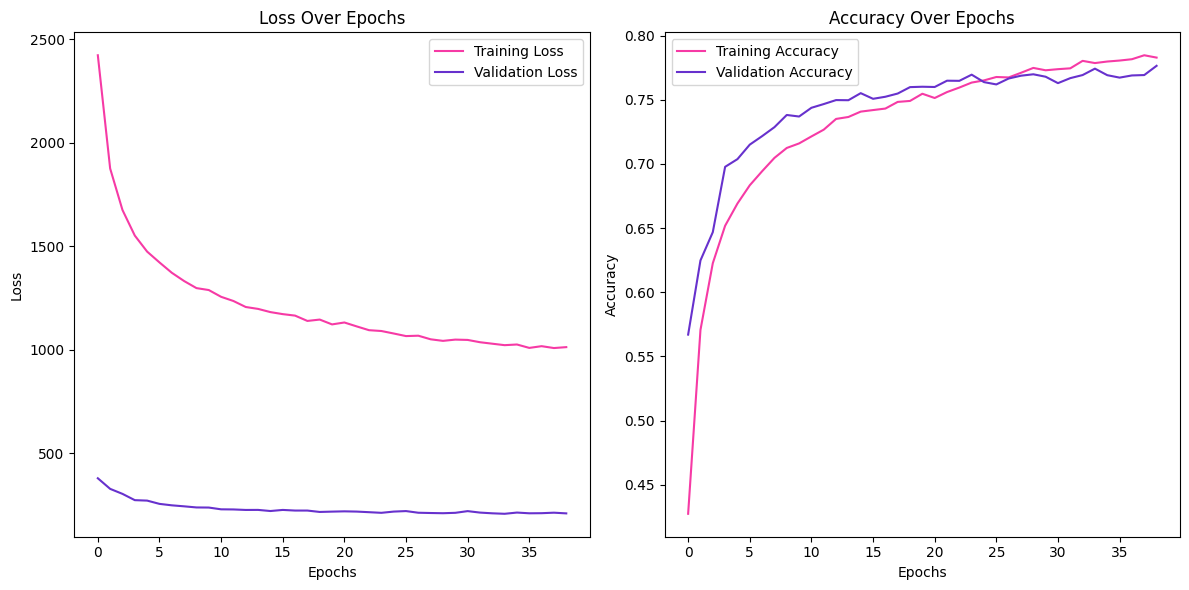

In [73]:
# Plotting loss and accuracy graphs after training
plt.figure(figsize=(12, 6))

# Loss plot
plt.subplot(1, 2, 1)
plt.plot(train_losses3, label='Training Loss',color='#f63aa5')
plt.plot(valid_losses3, label='Validation Loss',color='#6731cd')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss Over Epochs')
plt.legend()

# Accuracy plot
plt.subplot(1, 2, 2)
plt.plot(train_accuracies3, label='Training Accuracy',color='#f63aa5')
plt.plot(valid_accuracies3, label='Validation Accuracy',color='#6731cd')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Accuracy Over Epochs')
plt.legend()

plt.tight_layout()
plt.show()

1. Loss over Epochs:
The training loss started off really high but as the number of epochs increased, it decreased. This is an indication that our model was learning very well. On the other hand, the validation loss decreased with the training loss too. This is a good indication that the model is not overfitting anymore.

2. Accuracy over Epochs:
Both the training and validation accuracy started increasing together. At around 38 epochs, we notice the accuracies almost stay the same. Since we implemented the early stopping, the training stops where the accuracies are almost equal. This solves the issue of the possible overfitting that was caused in `model2`.

Confusion Matrix for `model3`

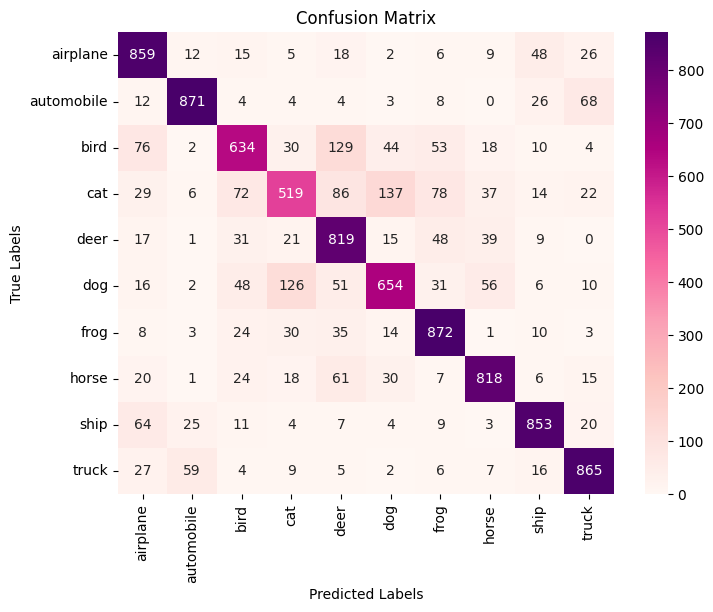

In [75]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import torch

# Step 1: Generate Predictions on the Test Set
all_preds = []
all_labels = []

model3.eval()  # Set model to evaluation mode
with torch.no_grad():
    for images, labels in testloader:
        images, labels = images.to(device), labels.to(device)
        outputs = model3(images)
        _, preds = torch.max(outputs, 1)  # Get predicted class (highest probability)
        all_preds.extend(preds.cpu().numpy())  
        all_labels.extend(labels.cpu().numpy())  

# Step 2: Compute the Confusion Matrix
cm = confusion_matrix(all_labels, all_preds)

# Step 3: Visualize the Confusion Matrix
class_names = testset.classes  # Class names from the CIFAR-10 dataset
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="RdPu", xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix")
plt.show()

### 6. Results and Discussions

`model1`:
* Training Accuracy: 0.9050
* Validation Accuracy: 0.7542

`model2`:
* Training Accuracy: 0.8042
* Validation Accuracy: 0.7739

`model3`:
* Training Accuracy: 0.7828
* Validation Accuracy: 0.7764

Initially we observed that without applying optimization techniques, our the model achieved a 75% accuracy on unseen data but it suffered from overfitting as the training accuracy was significantly higher at 90.5%. To address this, we introduced dropout as an optimization technique. This improved the unseen data accuracy to 77.4% while reducing overfitting. However, since this approach did not include early stopping, the model still overfitted slightly with a training accuracy of 80%. Finally, we implemented early stopping alongside the optimized model and doing this we were able to achieve the best results with 77.6% accuracy on unseen data and effectively preventing overfitting as the training accuracy was closely aligned at 78%.

### 7. Testing the Models performance

Here, I will test every models prediction and compare it with the actual output.

In [107]:
prediction1 = model1(x_gpu)
prediction1

tensor([[ 0.1323,  1.3848, -3.7171, -4.8572, -5.2073, -3.0935, -4.5661, -4.3093,
          0.2219, -0.4441]], device='cuda:0', grad_fn=<AddmmBackward0>)

In [108]:
prediction1.argmax(dim=1, keepdim=True)

tensor([[1]], device='cuda:0')

In [109]:
classes[solution]

'automobile'

In [110]:
prediction2 = model2(x_gpu)
prediction2

tensor([[ -1.8399,  -1.3389,  -7.6529,  -8.0119, -10.1427, -10.0568,  -9.5486,
          -8.7078,  -6.7069,  -3.5461]], device='cuda:0',
       grad_fn=<AddmmBackward0>)

In [111]:
prediction2.argmax(dim=1, keepdim=True)

tensor([[1]], device='cuda:0')

In [112]:
classes[solution]

'automobile'

In [113]:
prediction3 = model3(x_gpu)
prediction3

tensor([[-0.9964, -0.7105, -2.4595, -3.2439, -3.7260, -3.9721, -3.5139, -4.2847,
         -1.7826, -1.0863]], device='cuda:0', grad_fn=<AddmmBackward0>)

In [114]:
prediction3.argmax(dim=1, keepdim=True)

tensor([[1]], device='cuda:0')

In [115]:
classes[solution]

'automobile'

##### Our results cleary show that the models predicted the label corresponding to 1 which is "automobile" in the dataset.